In [220]:
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from openai import AzureOpenAI
import json
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
from tqdm import tqdm

In [2]:
llm = LLM(model="Qwen/Qwen2.5-0.5B-Instruct")

INFO 03-13 14:46:52 config.py:542] This model supports multiple tasks: {'classify', 'generate', 'reward', 'score', 'embed'}. Defaulting to 'generate'.
INFO 03-13 14:46:52 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='Qwen/Qwen2.5-0.5B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-0.5B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=Qwen/Qwen2.5-0.5B-Instruct, num_scheduler_

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  1.25it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  1.25it/s]


INFO 03-13 14:46:56 model_runner.py:1115] Loading model weights took 0.9277 GB


INFO 03-13 14:46:56 worker.py:267] Memory profiling takes 0.45 seconds
INFO 03-13 14:46:56 worker.py:267] the current vLLM instance can use total_gpu_memory (23.99GiB) x gpu_memory_utilization (0.90) = 21.59GiB
INFO 03-13 14:46:56 worker.py:267] model weights take 0.93GiB; non_torch_memory takes 0.08GiB; PyTorch activation peak memory takes 1.44GiB; the rest of the memory reserved for KV Cache is 19.14GiB.
INFO 03-13 14:46:56 executor_base.py:110] # CUDA blocks: 104553, # CPU blocks: 21845
INFO 03-13 14:46:56 executor_base.py:115] Maximum concurrency for 32768 tokens per request: 51.05x
INFO 03-13 14:46:57 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:08<00:00,  4.13it/s]

INFO 03-13 14:47:05 model_runner.py:1562] Graph capturing finished in 9 secs, took 0.88 GiB
INFO 03-13 14:47:05 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 9.51 seconds


In [221]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [3]:
test_hitom = load_dataset('parquet', data_files='data/test/test_hitom.parquet')['train']

In [4]:
test_hitom

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'prompt'],
    num_rows: 600
})

In [201]:
SYSTEM_PROMPT = """Think step-by-step. Provide the think first, and then the answer. Answer in the following JSON format:
{
"think": "step by step thinking",
"answer": "answer text"
}
"""
XML_COT_FORMAT = """Read the following story and answer the question. Story: {}\n Question:{}"""


# SYSTEM_PROMPT = """Read the following story and answer the question. Think step-by-step. Provide the answer first,and then explain it. Answer in the following JSON format:
# {
# "answer": "answer text",
# "explain": "step by step thinking"
# }
# """

# XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [210]:
import re

def extract_xml_answer(text: str) -> str:
    answer_pattern = r'<answer>(.*?)</answer>'
    matches = list(re.finditer(answer_pattern, text, re.DOTALL))
    if not matches:
        return None
        
    final_answer = matches[-1].group(1).strip()
    return final_answer



def normalize_answer(answer: str) -> str:
    """Normalizes the answer text for better comparison.
    Args:
        answer: Raw answer text
    Returns:
        Normalized answer text
    """
    if answer is None:
        return None
    # Convert to lowercase
    normalized = answer.lower()
    # Remove extra whitespace
    normalized = re.sub(r'\s+', ' ', normalized).strip()
    # Remove punctuation that doesn't affect meaning
    normalized = re.sub(r'[.,;:!?"{}]', '', normalized)
    return normalized


def reward_func(response, answer):
    response_ = response
    #response_ = extract_xml_answer(response)
    if response_:
        norm_response = normalize_answer(response_)
        norm_answer = normalize_answer(answer)
        ans_pattern = r".*?\b(?:in|at|on|inside|)?\s*(?:the\s*)?(?:\w+'s\s*)?" + re.escape(norm_answer) + r"\s*\b$"
        match = re.match(ans_pattern, norm_response, re.DOTALL | re.MULTILINE)
        if match:
            return 1
        else:
            return 0
    return 0

In [202]:
test_hitom['story'][0]

'Charlotte, Isabella, Elizabeth and Owen entered the living_room. lettuce is in the green_drawer. moved the lettuce to the green_bathtub. dislikes the tangerine. exited the living_room. moved the lettuce to the blue_pantry. likes the green_envelope. exited the living_room. made no movements and stayed in the living_room for 1 minute. exited the living_room. dislikes the green_pepper. made no movements and stayed in the living_room for 1 minute. exited the living_room. moved the lettuce to the green_drawer. exited the living_room. Charlotte, Isabella, Elizabeth and Owen entered the waiting_room.'

In [203]:
test_hitom['question'][0]

'Where is the lettuce really?'

In [228]:
sampling_params = SamplingParams(temperature=0.6, max_tokens=2048, top_p = 0.95)

In [205]:
i = 8
prompt_task =XML_COT_FORMAT.format(test_hitom['story'][i], test_hitom['question'][i])

outputs = llm.chat([
    [{"role": "system", "content":SYSTEM_PROMPT},
    {"role": "user", "content": prompt_task}]
    ], 
    sampling_params=sampling_params, 
    use_tqdm=False)

print(outputs[0].outputs[0].text)

{
"think": "Ava, Abigail, Ella and Owen entered the bedroom, saw a cat, and exited the bedroom. They then moved the banana to the green_envelope and exited the bedroom. Ava, Abigail, Ella, and Owen entered the waiting room.",
"answer": "The banana is in the green_envelope"
}


In [206]:
eval(outputs[0].outputs[0].text)

{'think': 'Ava, Abigail, Ella and Owen entered the bedroom, saw a cat, and exited the bedroom. They then moved the banana to the green_envelope and exited the bedroom. Ava, Abigail, Ella, and Owen entered the waiting room.',
 'answer': 'The banana is in the green_envelope'}

In [207]:
json.loads(outputs[0].outputs[0].text)['answer']

'The banana is in the green_envelope'

In [214]:
reward_func('For example, The banana is not in the green_envelope', 'green_envelope')

1

In [215]:
test_hitom['answer'][i]

'green_pantry'

In [216]:
prompt = []
for i in range(len(test_hitom)):
    prompt_task =XML_COT_FORMAT.format(test_hitom['story'][i], test_hitom['question'][i])
    prompt.append([{"role": "system", "content":SYSTEM_PROMPT},
    {"role": "user", "content": prompt_task}])

In [ ]:
prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)

In [217]:
df  = pd.DataFrame(test_hitom)
df['prompt'] = prompt
test_hitom = Dataset.from_pandas(df)

In [229]:
model_results = llm.chat(test_hitom['prompt'], sampling_params, use_tqdm=True)

Processed prompts: 100%|██████████| 600/600 [01:32<00:00,  6.47it/s, est. speed input: 1920.79 toks/s, output: 1172.76 toks/s]


In [230]:
results = {'output':[], 'answer':[]}
for each, answer in zip(model_results, test_hitom['answer']):
    results['output'].append(each.outputs[0].text)
    results['answer'].append(answer)

In [231]:
df = pd.DataFrame(results)
df.head(2)

,output,answer
0,"{\n""think"": ""Charlotte, Isabella, Elizabeth an...",green_drawer
1,"{\n""think"": ""Carter, Elizabeth, Hannah, and Ja...",blue_container


In [232]:
correct = []
for each, answer in zip(df.output, df.answer):
    try:
        res = eval(each)
        correct.append(reward_func(res['answer'], answer))
    except:
        #print(each)
        if 'answer' in each:
            try:
                response = normalize_answer(each.split('answer": "')[1].split('",')[0])
                print(each.split('answer": "')[1].split('",')[0], 'Answer:', answer, reward_func(response, answer))
                correct.append(reward_func(response, answer))
            except Exception as e:
                correct.append(0)
            # response = normalize_answer(each.split('answer')[-1])
            # correct.append(reward_func(response, answer))
        else:
            #print(each)
            correct.append(0)

The cabbage is in the green crate." Answer: blue_crate 0
The story doesn't provide enough information to determine where Abigail thinks Amelia thinks Hannah thinks Emily thinks the asparagus is. The answer cannot be determined based on the given information." Answer: green_bottle 0
Isla thinks Noah thinks the corn is in the blue_treasure_chest." Answer: blue_treasure_chest 1
The answer is that Jackson thinks the peas is in the blue_crate. Jackson and Jack both made no movements in the hallway, so they are likely not thinking about peas. The story mentions that Jackson, Jack, Emily and Isabella entered the hallway, and they exited it, so they are probably thinking about peas. The story also mentions that the peas is in the blue_suitcase, so they are probably thinking about the blue suitcase. However, it is not clear why they are thinking about peas in the first place. The story also mentions that the peas is in the blue_crate, so they are probably thinking about the blue crate. However,

In [233]:
np.mean(correct)

0.22166666666666668

In [193]:
df['reward']=correct

In [194]:
res['answer']

'waiting_room'

In [195]:
reward_func('d at the blue_pantry', 'blue_pantry')

1

In [196]:
response

'the green_pantry'

In [197]:
for each in ['deception','question_order','question']:
    df[each]=test_hitom[each]

In [198]:
df.head(2)

,prompt,answer,output,deception,question_order,question,reward
0,[{'content': 'Read the following story and ans...,green_drawer,"{\n""answer"": ""green_drawer"",\n""explain"": ""The ...",False,0,Where is the lettuce really?,1
1,[{'content': 'Read the following story and ans...,blue_container,"{\n""answer"": ""green_bottle"",\n""explain"": ""The ...",False,0,Where is the tomato really?,0


<Axes: xlabel='question_order', ylabel='reward'>

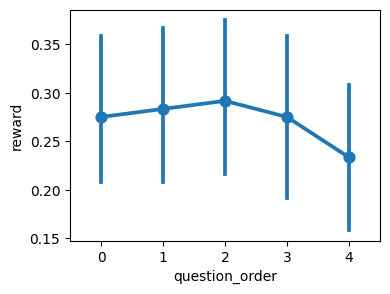

In [200]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.pointplot(x='question_order', y='reward', data=df)

<Axes: xlabel='question_order', ylabel='reward'>

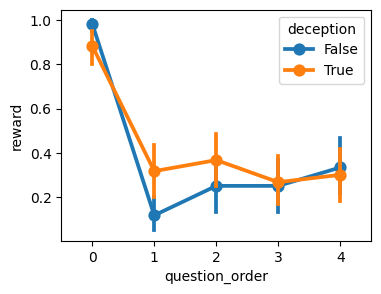

In [78]:
_, ax = plt.subplots(1,1,figsize=(4, 3))
sns.pointplot(x='question_order', y='reward', hue='deception', data=df)

In [79]:
df.reward.mean()

0.4066666666666667

In [77]:
df.to_csv('data/results/base/hittom_gpt4omini.csv', index=False)

0

In [122]:
reward_func("in A's box ", 'box')

1

In [110]:
reward_func(" in t's box ", 'box')

1

In [123]:
np.mean([1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

0.3375

In [126]:
np.array([1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).reshape(-1, 8)

array([[1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 1., 1., 1., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 1., 1., 0.],
       [1., 1., 0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 

In [125]:
np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).reshape(-1, 8)

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 

In [127]:
np.array([1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).reshape(-1, 8)

array([[1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 0.],
       [1., 1., 1., 0., 1., 1., 0., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 